<a href="https://colab.research.google.com/github/tteenathankachan/2021-CS109A/blob/master/cs109b_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 

## Homework 2: Bayesian Analysis



**Harvard University**<br/>
**Spring 2022**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas


<hr style="height:2pt">

In [ ]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/"
    "content/styles/cs109.css"
).text
HTML(styles)

<a id="instructions"></a>

<hr style="height:2pt">

### INSTRUCTIONS

- This homework can be submitted **in pairs**.

- To submit your assignment follow the instructions given in Canvas.

- Please **restart the kernel and run the entire notebook again before you submit. But remember that it can take a long time to run, so give yourself enough time.** 

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code continues to work, restart the kernel and rerun your notebook periodically while working through this assignment. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use `.head(...)` when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate and report $R^2$", do not just output the value from a cell. Write a `print(...)` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- **Your plots MUST be clearly labeled and easy to read,** including clear labels for the $x$ and $y$ axes, a descriptive title ("MSE plot" is NOT a descriptive title; "Training and validation MSE at varying degree polynomial regression models" on the other hand is descriptive), a legend when appropriate, and clearly formatted text and graphics.

- **Your code may also be evaluated for efficiency and clarity.** As a result, correct output is not always sufficient for full credit.

<hr style="height:2pt">

In [ ]:
import random
from datetime import datetime as dt

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.special import expit
import seaborn as sns

%matplotlib inline

print(f"Using PyMC3 version: {pm.__version__}")
print(f"Using ArviZ version: {az.__version__}")

Using PyMC3 version: 3.11.4
Using ArviZ version: 0.11.4


In [ ]:
# Ignore a common pymc3 warning that comes from library functions, not our code.
# Pymc3 may throw additional warnings, but other warnings should be manageable
# by following the instructions included within the warning messages.
import warnings

messages=[
    "Using `from_pymc3` without the model will be deprecated in a future release",
]

for m in messages:
    warnings.filterwarnings("ignore", message=m)
    

<a id="contents"></a>

## Notebook Contents

- [**Part 1: Rejection sampling and the weighted bootstrap**](#part1)
  - [Overview](#part1intro)
  - [Questions](#part1questions)
  - [Solutions](#part1solutions)


- [**Part 2: Bayesian Logistic Regression and Varying-Intercepts Model**](#part2)
  - [Overview](#part2intro)
  - [Questions](#part2questions)
  - [Solutions](#part2solutions)


- [**Part 3: Varying-Coefficients Model and Model Selection**](#part3)
  - [Overview](#part3intro)
  - [Questions](#part3questions)
  - [Solutions](#part3solutions)


## Dataset Information

### Contraceptive Usage by Bangladeshi Women

For this assignment, you are provided with data sets `dataset_2_train.csv` and `dataset_2_test.csv`containing details of contraceptive usage by 1,934 Bangladeshi women.

There are four attributes for each woman, along with a label `contraceptive_use` indicating if she uses contraceptives. The attributes include:

* `district`: identifying code for the district the woman lives in
* `urban`: type of region of residence
* `living.children`: number of living children
* `age-mean`: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


<a id="part1"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# Part 1:  Rejection sampling and the weighted bootstrap

[Return to contents](#contents)

<a id="part1intro"></a>

## Overview 

[Return to contents](#contents)

For the first part of the problem, we will only work with the label `contraceptive_use` and ignore all the attributes.  Let $Y_i$ be 1 if woman $i$ uses contraceptives, and 0 otherwise.  Assume a Bernoulli model for the data:

$$Y_{i} \sim \text{Bernoulli}(\theta)$$

where $i=1,\ldots,N$, with $N$ being the number of observations in the training data set, and $\theta$ is the unknown probability a woman uses contraception.  We will assume the following prior distribution on $\theta$:

$$\theta \sim \text{Normal}(0.5, 0.5^2)$$

subject to $0 \leq \theta \leq 1$.  This is sometimes called a truncated normal distribution.  A value from this distribution can be randomly drawn by simulating a value from $\text{Normal}(0.5, 0.5^2)$ and then keeping it if the value is between 0 and 1, and trying again if it is outside this range.  In fact, this is a form of rejection sampling.  The density for the truncated normal distribution is

$$p(\theta) = c\times\frac{1}{\sqrt{2\pi (0.5)^2}} \: \exp\left(\frac{-1}{2(0.5)^2}(\theta-0.5)^2\right) \; \text{for} \; 0\leq \theta \leq 1 \; \text{, and} \; 0 \; \text{otherwise,}$$

where $c$ is a normalizing constant that does not depend on $\theta$.

<a id="part1questions"></a>

### <div class='exercise'>Part 1: Questions</div> 

[Return to contents](#contents)

**1.1** Given the training data, what is the likelihood function $L(\theta | y_1,\ldots,y_n)$?  What is the MLE of $\theta$ as a function of the $y_1,\ldots,y_n$?  Compute the MLE from the data.

**1.2** Using rejection sampling, simulate a sample of 10,000 accepted values $\theta$ from the posterior distribution.  Plot a histogram of these values, and provide numerical summaries of the distribution of the 10,000 values. Interpret your findings.

**Note: make sure $\theta$ only takes on values which are valid for the parameter it represents and that all samples that do not pass the sampling criterion are rejected. Consult the lecture notes on rejection sampling if you need to review this criterion.**

**1.3** Carry out the weighted bootstrap to simulate 1,000 values of $\theta$ from the posterior distribution.  In doing so, simulate 10,000 values from the prior distribution to use as the discrete distribution from which the posterior draws will be simulated via the importance weights.  As above, plot a histogram of these values, and provide numerical summaries of the distribution of 1,000 values.  Interpret the results, and compare to the results of rejection sampling.


<a id="part1solutions"></a>

## Part 1: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**1.1**  Given the training data, what is the likelihood function $L(\theta | y_1,\ldots,y_n)$?  What is the MLE of $\theta$ as a function of the $y_1,\ldots,y_n$?  Compute the MLE from the data.



</div>

**your answer here**

In [ ]:
# your code here

dataset_2_train = pd.read_csv('data/dataset_2_train.csv')
dataset_2_train

# dataset_2_test = pd.read_csv('data/dataset_2_test.csv')
# dataset_2_test
# It will be a mix of both. For the first two, you should define the likelihood function 
# and derive the MLE function showing your work in a markdown cell.
# For the last section, you will use Python to calculate the actual MLE of the data using the function you derived. 

,district,urban,living.children,age_mean,contraceptive_use
0,35,0,4,2.4400,0
1,22,0,2,-1.5599,1
2,29,0,2,-8.5599,1
3,5,0,3,-4.5599,1
4,34,1,4,8.4400,0
...,...,...,...,...,...
962,45,0,2,-6.5599,0
963,27,0,2,-4.5599,0
964,35,0,4,-8.5599,1
965,7,0,3,1.4400,0


#The likelihood function is the probability of the data conditional on the parameters, viewed as a function of the parameters.

Likelihood function of Bernouli function is  
\begin{equation*}
L(θ|y1,...,yn)   = {n \choose i=1} θ^{yi} (1-θ)^{ 1-yi}
\end{equation*}
\begin{equation*}
𝐿(𝜃|𝑦1,…,𝑦𝑛) =L($\theta$|y) = $\theta^{377}$$(1-\theta)^{590}$
\end{equation*}

The log of likelihood function is 
\begin{equation*}
LogL(θ|y1,...,yn)   ={n \choose i=1}∑log θ^{yi} (1-θ)^{ 1-yi}                    
\end{equation*}

\begin{equation*}
={n \choose i=1}∑ yi log θ + (1-yi) log (1-θ)
\end{equation*}

\begin{equation*}
=Y log θ + (n - Y) log (1-θ) 
-->where Y = {n \choose i=1}∑ yi
\end{equation*}

#What is the MLE of  𝜃  as a function of the  𝑦1,…,𝑦𝑛 ?

to find MLE of θ, finding the derivative of log likelihood and setting to zero
\begin{equation*}
δ(LogL(θ|y1,...,yn)) = δ(Y log θ + (n - Y) log (1-θ)) = o
\end{equation*}

\begin{equation*}
= Y 1/θ + (n - Y) -1/(1-θ)) = o
\end{equation*}

\begin{equation*}
MLE of θ = Y/n = ({n \choose i=1}∑ yi)/n
\end{equation*}


In [ ]:
𝐿(𝜃|𝑦1,…,𝑦𝑛) =L($\theta$|y) = $\theta^{377}$$(1-\theta)^{590}$
MLE of  𝜃  as a function of the  𝑦1,…,𝑦𝑛 = derivative( $\theta^{377}$$(1-\theta)^{590}$)=0 
MLE  $\theta$ = 377/967 = .389

In [ ]:
# compute the MLE from the dataset for 'contraceptive_use'

sample_mean_contraceptive_use = np.sum(dataset_2_train['contraceptive_use'])/len(dataset_2_train)

display('MLE of θ from the dataset-->')
display(sample_mean_contraceptive_use)

'MLE of θ from the dataset-->'

0.38986556359875907

<div class='exercise-r'>

**1.2**  Using rejection sampling, simulate a sample of 10,000 accepted values $\theta$ from the posterior distribution.  Plot a histogram of these values, and provide numerical summaries of the distribution of the 10,000 values. Interpret your findings.

**Note: make sure $\theta$ only takes on values which are valid for the parameter it represents and that all samples that do not pass the sampling criterion are rejected. Consult the lecture notes on rejection sampling if you need to review this criterion.**



</div>

In [ ]:
# y = dataset_2_train['contraceptive_use'].values

# x ='θ'

# for yi in y:
#     np.dot(x**yi * (1-x)**(1-yi))

In [ ]:
# your code here


y = dataset_2_train['contraceptive_use']
#page 32 step3 --When we set M to the likelihood function and when the proposed distribution density g(x) 
#is equal to the prior density p(x), we do not care about what our prior is anymore. 
#can do the simulation by using the likelihood function.
# step 3 of Bayesian rejection sampling compares the simulated value from a 
#uniform distribution with the ratio of two likelihood functions.
#ratio of two likelihood functions 
#--> Likelihood function for the observed y values / likelyhood function at MLE = 0.39
def h(θ):
    val = 1
    for yi in y:
        val  = val * ((θ**yi * (1-θ)**(1-yi))/(0.39**yi * (1-0.39)**(1-yi)))
    return val

def h1(θ):
    val = (θ**377 * (1-θ)**590) / (0.39**377 * (1-0.39)**590)
    return val    

# def g(x):
#     return st.norm.pdf(x, loc=0.5, scale=0.5)


# def h(θ,yi):
# #     p = 1/(np.sqrt(2*np.pi*(0.5)**2)) * np.exp(-0.5*((θ-0.5)/0.5)**2)
# #     L = np.dot(θ**yi * (1-θ)**(1-yi))
# #     return p * L
    
# #     (θ**yi * (1-θ)**(1-yi))/0.39
    
#     return (θ**yi * (1-θ)**(1-yi))/(0.39**yi * (1-0.39)**(1-yi))




Rejection rate is 96.97131226981973


'sample size = 10000'

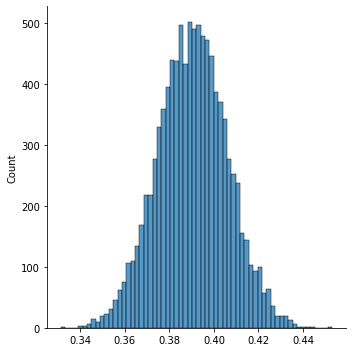

In [ ]:
def rejection_sampling(maxiter=100000,sampsize=1000):
    samples = []
    sampcount = 0  # counter for accepted samples
    maxcount = 0   # counter for proposal simulation
    # sampcount/maxcount at any point in the iteration is the acceptance rate

    while (sampcount < sampsize and maxcount < maxiter):
        z = np.random.normal(0.5, 0.5) ## truncate between 0, 1
        u = np.random.uniform(0, 1)
        maxcount += 1
        hval = 0
        ## truncate between 0, 1
        if z >=0 and z <=1:
            hval = h1(z)
        # step 3 of Bayesian rejection sampling compares the simulated value from a 
        # uniform distribution with the ratio of two likelihood functions.
        if u <= hval:
            samples.append(z)
            sampcount += 1
    
    print('Rejection rate is',100*(1-sampcount/maxcount))
    
    if maxcount == maxiter: print('Maximum iterations achieved')
    display(f"sample size = {sampcount}")
    return np.array(samples)

s = rejection_sampling(maxiter=1000000,sampsize=10000)
sns.displot(s);




In [ ]:
# number summary
from numpy import percentile

# calculate quartiles
quartiles = percentile(s, [25, 50, 75])
# calculate min/max
s_min, s_max, s_mean, s_std = s.min(), s.max(), s.mean(), s.std()

# print 5-number summary
print('Min: %.3f' % s_min)
print('Max: %.3f' % s_max)
print('Q1: %.3f' % quartiles[0])
print('Median: %.3f' % quartiles[1])
print('Q3: %.3f' % quartiles[2])
print('mean: %.3f' % s_mean)
print('std deviation: %.3f' % s_std)



#mean , mode, variance, credible intervals


Min: 0.331
Max: 0.453
Q1: 0.380
Median: 0.390
Q3: 0.401
mean: 0.390
std deviation: 0.016


In [ ]:
#the  summary statistic of the posterior distribution 

# θ ∼ Be(378, 591)


Mean_x = 378/(378+591)

var_x = (378*591)/(((378+591)**2) * (378+591+1))

mode_x = (378-1)/(378+591-2)


print('Mean_x =', Mean_x)
print('var_x =', var_x)
print('mode_x =', mode_x)

print("The 2.5% and 97.5% of quantiles:", np.percentile(s,[2.5,97.5])) 

Mean_x = 0.39009287925696595
var_x = 0.0002452787884638929
mode_x = 0.38986556359875907
The 2.5% and 97.5% of quantiles: [0.35965164 0.42142816]


**your answer here**

mean of the sample is same as the MLE of the likelyhood function of the θ.


<div class='exercise-r'>

**1.3**  Carry out the weighted bootstrap to simulate 1,000 values of $\theta$ from the posterior distribution.  In doing so, simulate 10,000 values from the prior distribution to use as the discrete distribution from which the posterior draws will be simulated via the importance weights.  As above, plot a histogram of these values, and provide numerical summaries of the distribution of 1,000 values.  Interpret the results, and compare to the results of rejection sampling.


</div>

In [ ]:
y = dataset_2_train['contraceptive_use']

def l(θk):
    val = 1
    for yi in y:
        val  = val * (θk**yi * (1-θk)**(1-yi))
    return val

def l1(θk):
    val = (θk**377 * (1-θk)**590) / (0.39**377 * (1-0.39)**590)
    return val    




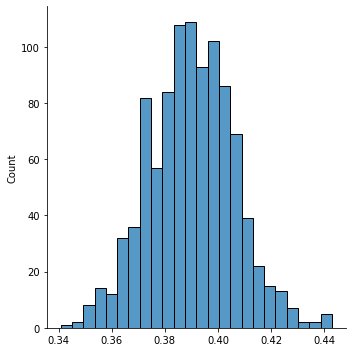

In [ ]:
# your code here

# weighted bootstrap computation involving likelihood at θk L(θk|y) --page 32 lecture slide
import random

def weighted_bootstrap(iter=1000,size=100):
    w = []
    y = []
    
    for i in range(iter):
        z = np.random.normal(0.5, 0.5) ## truncate between 0, 1
        if z >=0 and z <=1:
          y.append(z)
          # wz = h(z)/g(z)
          # wz = l(z)
          wz = l1(z)
          w.append(wz)
        else:
          continue
    # print(len(y))    
#     print(w)
    v = random.choices(y,weights=w,k=size) # do not need to renormalize w
    return np.array(v)

wb = weighted_bootstrap(iter=10000,size=1000)
sns.displot(wb);

# len(wb)

In [ ]:
# provide numerical summaries of the distribution of 1,000 values. 

# Interpret the results, and compare to the results of rejection sampling.

**your answer here**

<a id="part2"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# Part 2: Bayesian Logistic Regression and Varying-Intercepts Model

[Return to contents](#contents)



<a id="part2intro"></a>

## Overview 

[Return to contents](#contents)

The second model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distributions:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_1 &\sim N(0,10000) 
\\ \\ 
\beta_2 &\sim N(0,10000)
\\ \\ 
\beta_3 &\sim N(0,10000)
\\ \\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} & \sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}
\\ \\
\end{split}
$$

Where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

**PLEASE NOTE:** The $\text{Gamma}$ distribution cited above, uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate.  

<a id="part2questions"></a>

### <div class='exercise'>Part 2: Questions</div> 

[Return to contents](#contents)


**2.1** As a preprocessing step, map the district number 61 to the number 54 so that the numbering is consecutive with no gaps. Also, re-name district 60 to be district 0 so that the districts are now numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**

**2.2** We should verify that pymc3 can indeed recover the hidden parameter values. To do this, we'll hard-code known values of our choosing for the model parameters and simulate data from the model. Then, using this simulated data, we'll check if pymc3 can get back the parameter values we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

**Note: These hard-coded parameters will be used in question 2.2 - 2.5**.

Use the following hard-coded values:

$$
\begin{split}
\mu_0 &= 2
\\ \\
\sigma^2_0 &= 1
\\ \\
\beta_{0j} &\sim N(\mu_0,\sigma_0^2) \; \text{for all sixty districts}
\\ \\
\beta_1 &= 4
\\ \\ 
\beta_2 &= -3
\\ \\
\beta_3 &= -2
\\ \\
\end{split}
$$

**Verify that these parameters generate data in which an average of 46 to 48 percent of subjects use contraceptives.**

**2.3** Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.

**2.4** Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?

**2.5** Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions?

**Hint: The `az.plot_posterior()` function might be helpful here.**

**2.6** We now fit our model to the *actual* data. Fit the varying-intercept model to the real training data.

**2.7** Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

**2.8** Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?

**2.9** What are the posterior means of $\mu_0$ and $\sigma_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts?

<a id="part2solutions"></a>

## Part 2: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**2.1**  As a preprocessing step, map the district number 61 to the number 54 so that the numbering is consecutive with no gaps. Also, re-name district 60 to be district 0 so that the districts are now numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**



</div>

In [ ]:
# your code here

dataset_2_train.loc[dataset_2_train.district == 61 , 'district'] = 54
dataset_2_train.loc[dataset_2_train.district == 60 , 'district'] = 0
    
districts = dataset_2_train['district'].sort_values()
print(districts.unique())


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]


<div class='exercise-r'>

**2.2**  We should verify that pymc3 can indeed recover the hidden parameter values. To do this, we'll hard-code known values of our choosing for the model parameters and simulate data from the model. Then, using this simulated data, we'll check if pymc3 can get back the parameter values we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

**Note: These hard-coded parameters will be used in question 2.2 - 2.5**.

Use the following hard-coded values:

$$
\begin{split}
\mu_0 &= 2
\\ \\
\sigma^2_0 &= 1
\\ \\
\beta_{0j} &\sim N(\mu_0,\sigma_0^2) \; \text{for all sixty districts}
\\ \\
\beta_1 &= 4
\\ \\ 
\beta_2 &= -3
\\ \\
\beta_3 &= -2
\\ \\
\end{split}
$$

**Verify that these parameters generate data in which an average of 46 to 48 percent of subjects use contraceptives.**



</div>

In [ ]:
np.random.seed(123)

# True parameter values < --- our model does not see these
sigma = 1
# beta0 = 2
beta0_mu = 2
beta0_sigma = 1
size = 60
beta0 = np.random.normal(beta0_mu, beta0_sigma, size) 
betas = [4, -3, -2]  
X_1 = dataset_2_train['urban']
X_2 = dataset_2_train['living.children']
X_3 = dataset_2_train['age_mean']
# size = len(X_1)

# Simulate outcome variable
# l_y = beta0 + betas[0]*X_1 + betas[1]*X_2 +  betas[2]*X_3 + np.random.randn(size)*sigma
l_y = beta0[dataset_2_train['district']] + betas[0]*X_1 + betas[1]*X_2 +  betas[2]*X_3 
pr = 1/(1+np.exp(-l_y))
Y_simulated = np.random.binomial(n=1, p=pr)
count_elements = np.bincount(Y_simulated)
print('Total occurences of "1" in Y_simulated: ', count_elements[1])
print('total of Y_simulated: ', len(Y_simulated))
print(f'percent of subjects use contraceptives = {count_elements[1]/len(Y_simulated)*100 }%')

Total occurences of "1" in Y_simulated:  459
total of Y_simulated:  967
percent of subjects use contraceptives = 47.46639089968976%


In [ ]:
beta0[19] #2.386186399174856

2.386186399174856

In [ ]:
# from pymc3 import model_to_graphviz
# model_to_graphviz(district_model)

In [ ]:
# az.plot_trace(trace, compact=False);

<div class='exercise-r'>

**2.3**  Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.



</div>

In [ ]:
# your code here
# X_1 = dataset_2_train['urban']
# X_2 = dataset_2_train['living.children']
# X_3 = dataset_2_train['age_mean']
num_districts = len(districts.unique())


with pm.Model() as district_model_onsimulated:

    beta0_mu = pm.Normal('beta0_mu', mu=0, sd=100) 
    tau_beta0 = pm.Gamma('tau_beta0', alpha=.1, beta=.1)
    beta0 = pm.Normal('beta0', mu=beta0_mu, tau=tau_beta0, shape=num_districts)
    betas = pm.Normal('betas', mu=0, sd=100, shape=3)
    intercepts = beta0[dataset_2_train['district']]
    # p_logit = beta0 + betas[0] * X_1 + betas[1] * X_2 + betas[2] * X_3
    p_logit = intercepts + betas[0] * X_1 + betas[1] * X_2 + betas[2] * X_3
    contraceptive_use = pm.Bernoulli('obs_contraceptive_use', logit_p=p_logit, observed=Y_simulated)
    trace_onsimulated = pm.sample(2000, tune=3000, target_accept=0.9)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas, beta0, tau_beta0, beta0_mu]


Sampling 2 chains for 3_000 tune and 2_000 draw iterations (6_000 + 4_000 draws total) took 100 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
# def trace_summary(trace, var_names=None):
#     if var_names is None:
#         var_names = trace.varnames

#     quants = [0.025,0.25,0.5,0.75,0.975]
#     colnames = ['mean', 'sd', *["{}%".format(x*100) for x in quants]]
#     rownames = []

#     series = []
#     for cur_var in var_names:
#         var_trace = trace[cur_var]
#         if var_trace.ndim == 1:
#             vals = [np.mean(var_trace, axis=0), np.std(var_trace, axis=0), *np.quantile(var_trace, quants, axis=0)]
#             series.append(pd.Series(vals, colnames))
#             rownames.append(cur_var)
#         else:
#             for i in range(var_trace.shape[1]):
#                 cur_col = var_trace[:,i]
#                 vals = [np.mean(cur_col, axis=0), np.std(cur_col, axis=0), *np.quantile(cur_col, quants, axis=0)]
#                 series.append(pd.Series(vals, colnames))
#                 rownames.append("{}[{}]".format(cur_var,i))

#     return pd.DataFrame(series, index=rownames)

# trace_summary(trace, var_names=['beta0', 'betas','tau_beta0'])

# # sigma = 1
# # beta0 = 2
# # betas = [4, -3, -2]  

<div class='exercise-r'>

**2.4**  Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?



</div>

In [ ]:
# your code here
# az.plot_posterior(trace, var_names=['beta0']);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


<xarray.Dataset>
Dimensions:      (beta0_dim_0: 60, betas_dim_0: 3)
Coordinates:
  * beta0_dim_0  (beta0_dim_0) int64 0 1 2 3 4 5 6 7 ... 52 53 54 55 56 57 58 59
  * betas_dim_0  (betas_dim_0) int64 0 1 2
Data variables:
    beta0_mu     float64 1.012
    beta0        (beta0_dim_0) float64 1.005 1.004 1.002 ... 1.002 1.003 1.003
    betas        (betas_dim_0) float64 1.007 1.007 1.007
    tau_beta0    float64 1.008

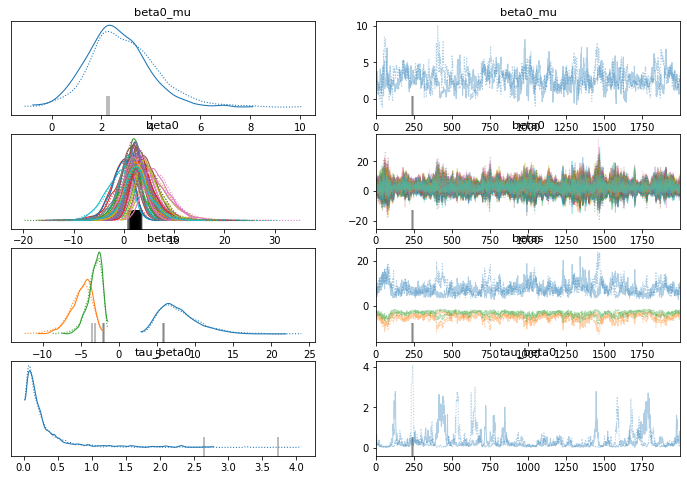

In [ ]:
from pymc3 import traceplot, compareplot, plot_posterior, forestplot
traceplot(trace_onsimulated);
pm.rhat(trace_onsimulated)

In [ ]:
az.summary(trace_onsimulated)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0_mu,2.795,1.304,0.432,5.270,0.086,0.061,230.0,438.0,1.01
beta0[0],2.475,2.800,-2.894,7.791,0.091,0.088,957.0,826.0,1.01
beta0[1],2.438,1.909,-1.104,6.118,0.082,0.060,535.0,1041.0,1.00
beta0[2],3.214,2.993,-2.288,8.804,0.114,0.101,781.0,832.0,1.00
beta0[3],0.106,2.720,-5.154,4.820,0.173,0.122,270.0,414.0,1.01
...,...,...,...,...,...,...,...,...,...
beta0[59],2.784,3.086,-3.268,8.479,0.093,0.099,1037.0,979.0,1.00
betas[0],7.958,2.769,3.699,13.088,0.249,0.177,128.0,299.0,1.01
betas[1],-5.050,1.494,-7.744,-2.528,0.135,0.096,121.0,187.0,1.01
betas[2],-3.223,0.990,-4.994,-1.673,0.091,0.064,120.0,279.0,1.01


**your answer here**

The betas (betas[0],betas[1], betas[2]) they converged fine and the Rhat value = 1.01 confirms that.

The beta0 

tao_beta0


<div class='exercise-r'>

**2.5**  Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions?

**Hint: The `az.plot_posterior()` function might be helpful here.**



</div>

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/plots/plot_utils.py:277: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (61) in plot_posterior, generating only 40 plots
  UserWarning,


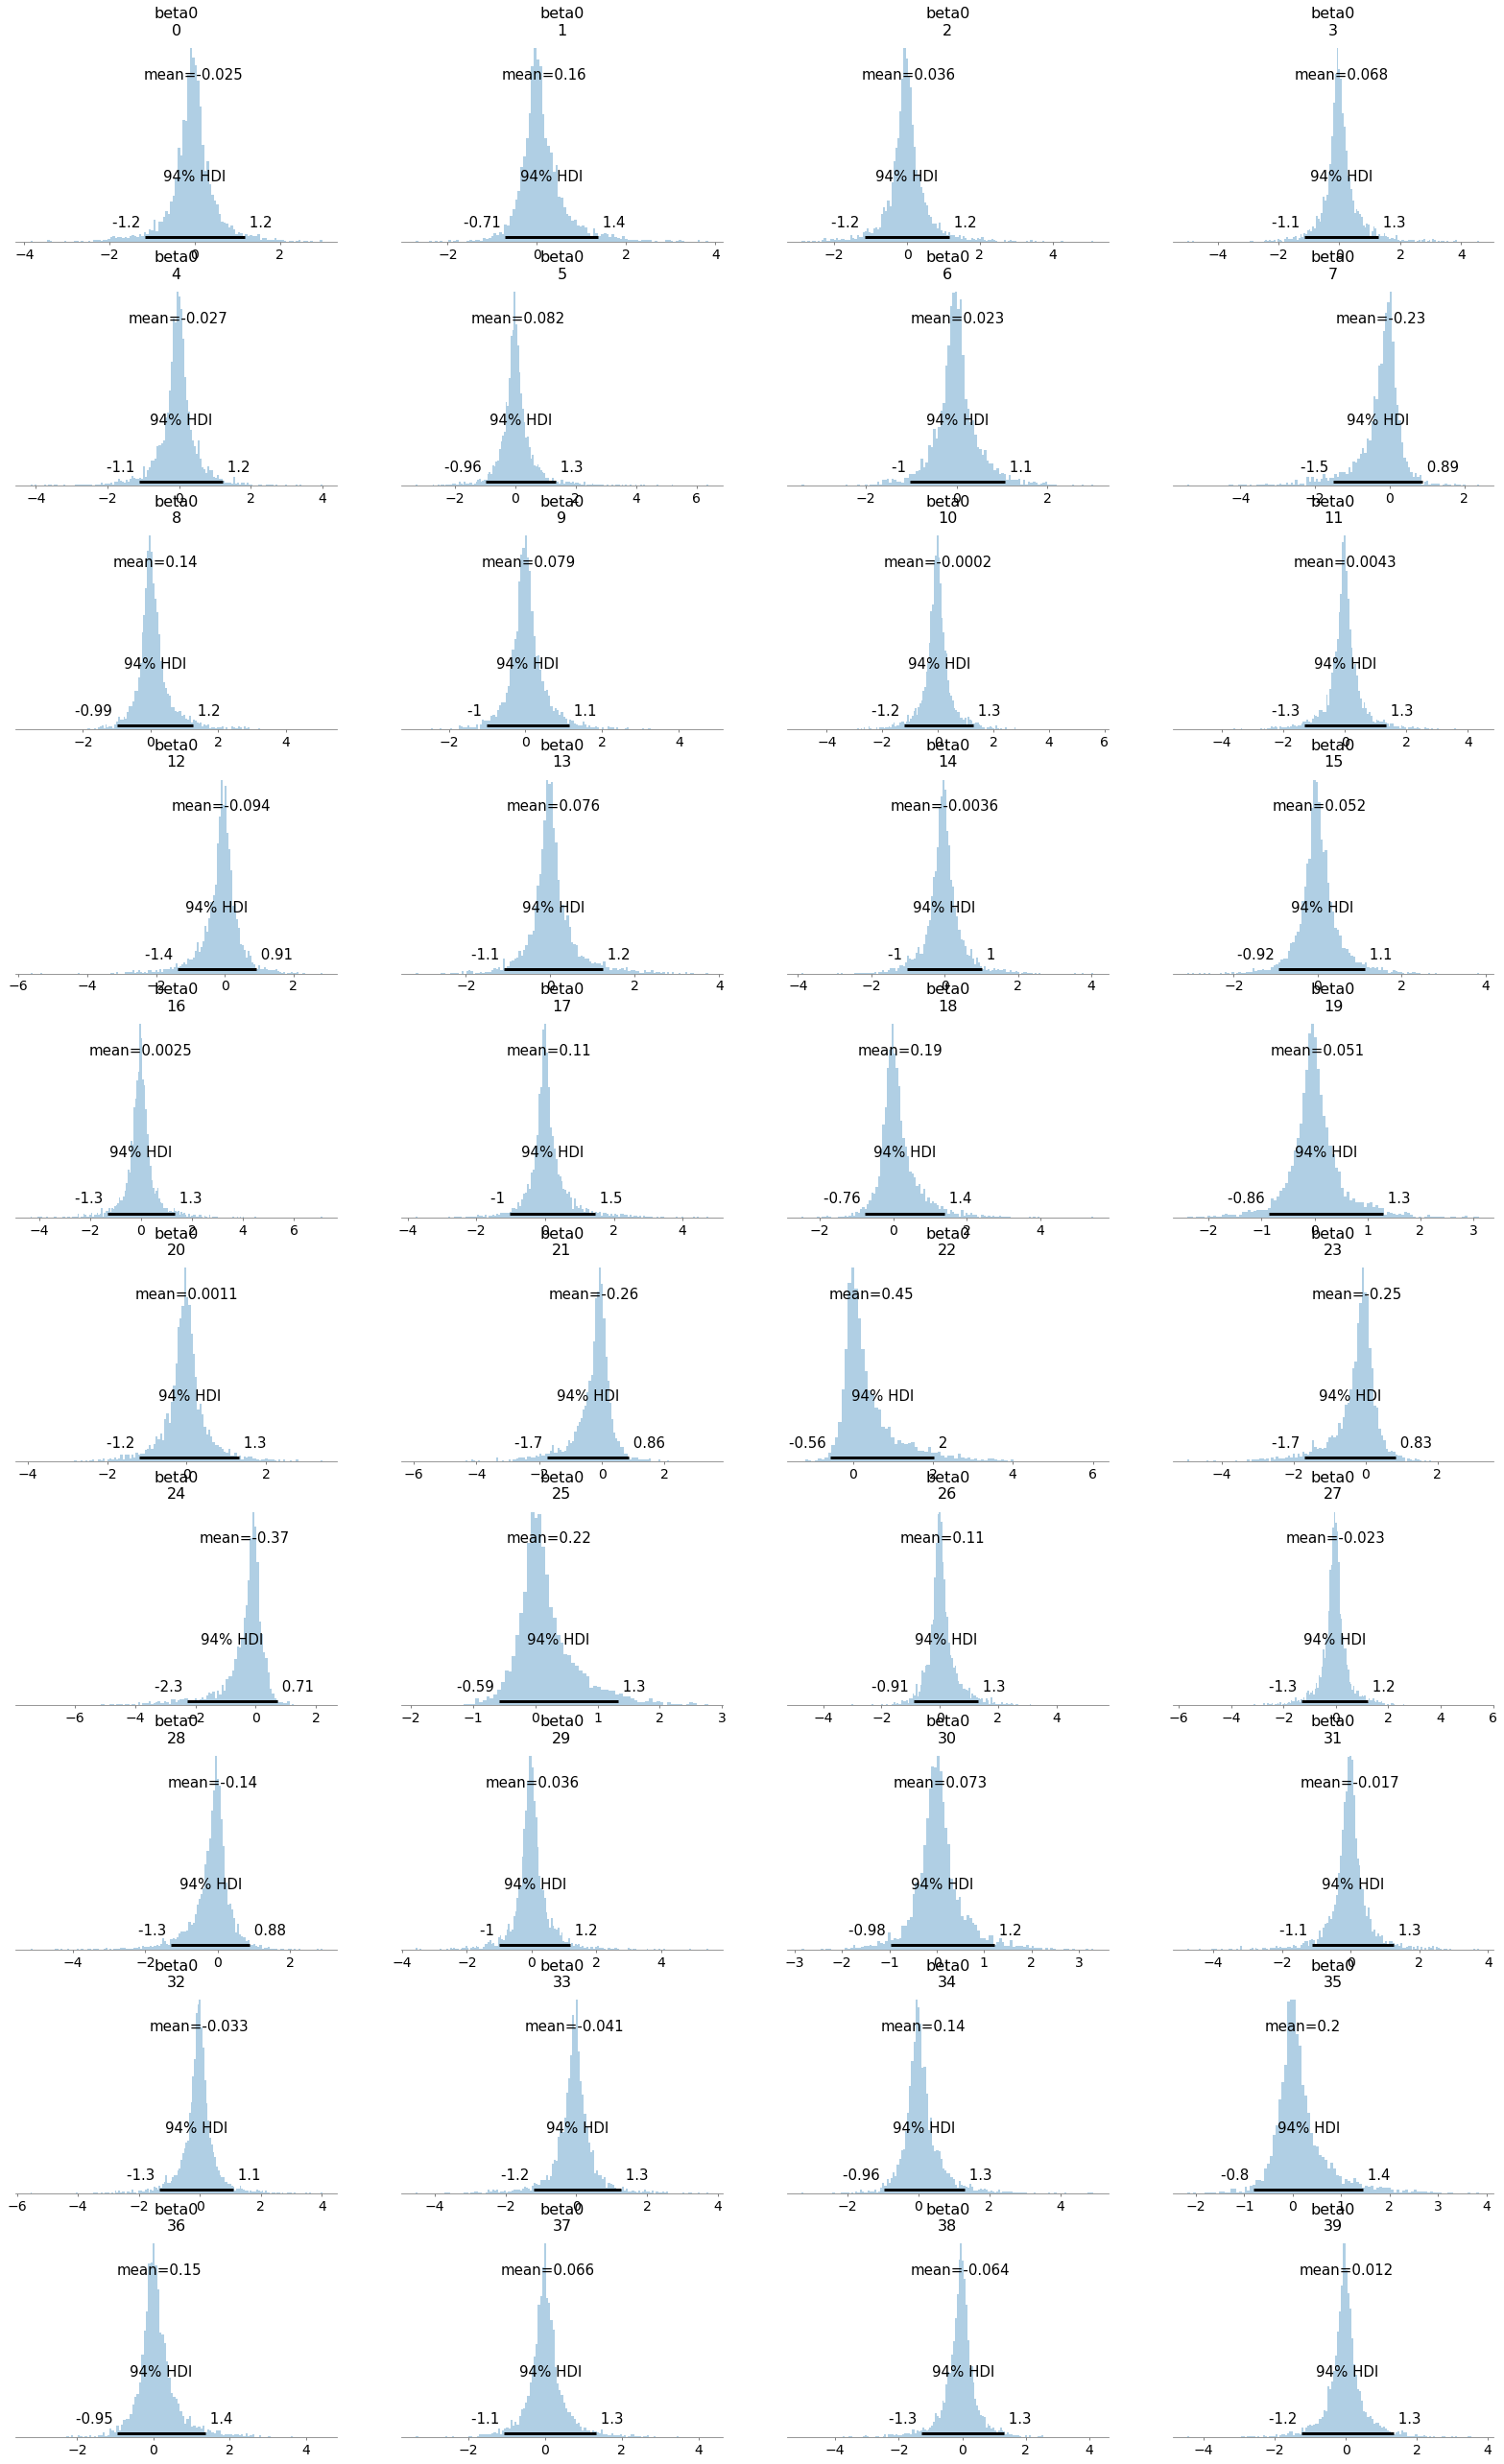

In [ ]:
# your code here

az.plot_posterior(trace_onsimulated, var_names=['beta0'],filter_vars="like", kind = 'hist');


**your answer here**

<div class='exercise-r'>

**2.6**  We now fit our model to the *actual* data. Fit the varying-intercept model to the real training data.



</div>

In [ ]:
# your code here
X_1 = dataset_2_train['urban']
X_2 = dataset_2_train['living.children']
X_3 = dataset_2_train['age_mean']
num_districts = len(districts.unique())


with pm.Model() as district_model_realdata:

    tau_beta0 = pm.Gamma('tau_beta0', alpha=.01, beta=.01)
    beta0_mu = pm.Normal('beta0_mu', mu=0, sd=100) 
    beta0 = pm.Normal('beta0', mu=beta0_mu, tau=tau_beta0, shape=num_districts)
    betas = pm.Normal('betas', mu=0, sd=100, shape=3)
    intercepts = beta0[dataset_2_train['district']]
    # p_logit = beta0 + betas[0] * X_1 + betas[1] * X_2 + betas[2] * X_3
    p_logit = intercepts + betas[0] * X_1 + betas[1] * X_2 + betas[2] * X_3
    contraceptive_use = pm.Bernoulli('obs_contraceptive_use', logit_p=p_logit, observed=dataset_2_train['contraceptive_use'])
    trace_realdata = pm.sample(2000, tune=3000, target_accept=0.9)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [betas, beta0, tau_beta0]


Sampling 2 chains for 3_000 tune and 2_000 draw iterations (6_000 + 4_000 draws total) took 49 seconds.
The number of effective samples is smaller than 25% for some parameters.


<div class='exercise-r'>

**2.7**  Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?



</div>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0[0],-0.658,0.458,-1.497,0.214,0.009,0.007,2698.0,2294.0,1.00
beta0[1],-0.628,0.291,-1.187,-0.086,0.005,0.004,3135.0,2598.0,1.00
beta0[2],-0.265,0.457,-1.144,0.563,0.006,0.007,5859.0,2647.0,1.00
beta0[3],0.177,0.578,-0.934,1.291,0.007,0.011,6570.0,2532.0,1.00
beta0[4],0.086,0.432,-0.762,0.885,0.005,0.008,7648.0,2552.0,1.00
...,...,...,...,...,...,...,...,...,...
beta0[59],-0.330,0.506,-1.282,0.607,0.007,0.009,5315.0,2288.0,1.00
betas[0],0.445,0.157,0.172,0.757,0.002,0.002,5330.0,3111.0,1.00
betas[1],-0.135,0.043,-0.213,-0.055,0.001,0.001,1772.0,2184.0,1.00
betas[2],0.010,0.009,-0.006,0.026,0.000,0.000,3683.0,3096.0,1.00


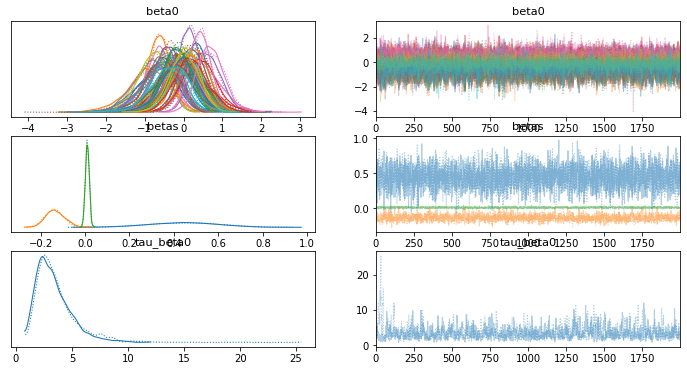

In [ ]:
# your code here
traceplot(trace);
# pm.rhat(trace)
az.summary(trace)

**your answer here**

based on the trace plots and Rhat, beta0, betas and tau_beta0 are converging very nicely. All have Rhat values = 1 or <=1.01

<div class='exercise-r'>

**2.8**  Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?



</div>

In [ ]:
# your code here

summary = az.summary(trace, var_names=["^beta0"], filter_vars="regex")
summary['mean'].sort_values()

Got error No model on context stack. trying to find log_likelihood in translation.


beta0[11]   -0.897
beta0[27]   -0.858
beta0[28]   -0.806
beta0[10]   -0.725
beta0[0]    -0.658
beta0[6]    -0.642
beta0[57]   -0.636
beta0[1]    -0.628
beta0[17]   -0.627
beta0[7]    -0.574
beta0[24]   -0.572
beta0[9]    -0.552
beta0[45]   -0.544
beta0[54]   -0.481
beta0[18]   -0.457
beta0[25]   -0.415
beta0[29]   -0.408
beta0[59]   -0.330
beta0[55]   -0.281
beta0[49]   -0.277
beta0[21]   -0.276
beta0[2]    -0.265
beta0[38]   -0.255
beta0[12]   -0.236
beta0[15]   -0.233
beta0[22]   -0.219
beta0[40]   -0.213
beta0[23]   -0.181
beta0[5]    -0.169
beta0[52]   -0.163
beta0[32]   -0.150
beta0[44]   -0.137
beta0[26]   -0.122
beta0[50]   -0.118
beta0[13]   -0.071
beta0[36]   -0.033
beta0[47]   -0.019
beta0[41]   -0.015
beta0[58]    0.014
beta0[37]    0.027
beta0[42]    0.032
beta0[8]     0.052
beta0[48]    0.065
beta0[33]    0.077
beta0[4]     0.086
beta0[20]    0.096
beta0[19]    0.112
beta0[14]    0.134
beta0[39]    0.144
beta0[51]    0.167
beta0[3]     0.177
beta0[53]    0.201
beta0[35]   

**your answer here**

Highest base rate of contraceptive usage (independent of other factors like urban population) is for district 57. 

Lowest base rate of contraceptive usage (independent of other factors like urban population) is for district 12. 

<div class='exercise-r'>

**2.9**  What are the posterior means of $\mu_0$ and $\sigma_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts?

</div>

In [ ]:
# your code here

posterior_means_mu0 = trace['beta0'].mean(axis=0)
posterior_means_sigma0 = np.sqrt(trace['tau_beta0'].mean(axis=0))
print('Posterior means of μ0', posterior_means_mu0)
print("")
print('Posterior means of sigma0', posterior_means_sigma0)

Posterior means of μ0 [-0.65765125 -0.62842108 -0.26455027  0.17702129  0.08598429 -0.16870629
 -0.64208082 -0.57367834  0.05153954 -0.55242256 -0.72452303 -0.89656633
 -0.23630351 -0.0708777   0.13436376 -0.23283804  0.48361994 -0.62687964
 -0.45708208  0.11237259  0.09560507 -0.27608383 -0.21945496 -0.18101016
 -0.57197949 -0.41479701 -0.12202791 -0.85793285 -0.80603262 -0.40812525
  0.31925534  0.31870417 -0.14982477  0.07742289  0.57891183  0.21318413
 -0.03268903  0.02676423 -0.25473421  0.14392717 -0.21338953 -0.01494267
  0.03175312  0.41400973 -0.13719709 -0.54431654  0.43357307 -0.01873592
  0.06536918 -0.27685409 -0.11834224  0.16695734 -0.16262889  0.20140457
 -0.48052957 -0.28073045  0.70774736 -0.63577428  0.01411276 -0.32971419]

Posterior means of sigma0 1.869072111530981


**your answer here**

The posterior means μ0 for many ditricts are showing -ve. Can the base rate of contraceptive usage -ve? it should be 0 or up. Looks like these shows evidences against the varying intercept model.

<a id="part3"></a>
    
<!-- <div class="alert alert-block alert-danger" style="color:black;background-color:#E7F4FA"> -->

# Part 3: Varying-Coefficients Model and Model Selection

[Return to contents](#contents)


<a id="part3intro"></a>

## Overview 

[Return to contents](#contents)

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on `living.children`, `age_mean`, and `urban` vary by district.

Prior distribution:

$$
\begin{split}
\beta_{0j} &\sim N(\mu_0,\sigma_0^2)\; \text{, with} \;\; \mu_0 \sim N(0,10000)\; \text{and} \; \; \frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)
\\
\beta_{1j} &\sim N(0,\sigma_1^2)\; \text{, with} \;\; \frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1) 
\\
\beta_{2j} &\sim N(0,\sigma_2^2)\; \text{, with} \;\; \frac{1}{\sigma^2_2} \sim \text{Gamma}(0.1,0.1)
\\ 
\beta_{3j} &\sim N(0,\sigma_3^2)\; \text{, with} \;\; \frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)
\\
\end{split}
$$

Model for data:

$$
\begin{split}
Y_{ij} &\sim \text{Bernoulli}(p_{ij})
\\ \\
\text{logit}\:p_{ij} &= \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}
\\ \\
\end{split}
$$

**PLEASE NOTE:** Once again, the $\text{Gamma}$ distribution uses the $\text{Gamma}(\alpha, \beta)$ parametrization, where $\alpha$ is the shape and $\beta$ is the rate. 

<a id="part3questions"></a>

### <div class='exercise'>Part 3: Questions</div> 

[Return to contents](#contents)

**3.1** Fit the varying-coefficients model described above to the real training data.

**3.2** Check the convergence of your varying-coefficients model by examining the trace plots and R-hats, as you did with the prior varying-intercepts model. What do you observe?

**3.3** Plot the distributions of posterior means and credible intervals for each predictor's coefficient by district. What do you conclude from these graphs?

**HINT:** The ArviZ [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) function is very well-suited for this task.

**3.4** Use all of the information you've gleaned thus far to build Bayesian logistic regression classifiers for both your varying-intercepts model (from 2.7) and your varying-coefficients model (from 3.1). Then, use each model to make predictions on your training and test sets.

  - Report each model's classification percentages and accuracy scores on both the training and test sets, as well as the trivial accuracy scores you would achieve with a "naive" model that predicts only the most frequent outcome observed in your training data.
  
  
  - What do you observe from these results?
  
  
  - Which model appears to be the best (i.e. varying-intercept or varying-coefficient), and what is your rationale?

<a id="part3solutions"></a>

## Part 3: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**3.1**  Fit the varying-coefficients model described above to the real training data.



</div>

In [ ]:
# your code here

num_districts = len(districts.unique())


with pm.Model() as district_model_var_coeff:

    beta0_mu = pm.Normal('beta0_mu', mu=0, sd=100) 
    tau_beta0 = pm.Gamma('tau_beta0', alpha=.1, beta=.1)
    tau_beta1 = pm.Gamma('tau_beta1', alpha=.1, beta=.1)
    tau_beta2 = pm.Gamma('tau_beta2', alpha=.1, beta=.1)
    tau_beta3 = pm.Gamma('tau_beta3', alpha=.1, beta=.1)
    beta0 = pm.Normal('beta0', mu=beta0_mu, tau=tau_beta0, shape=num_districts)
    beta1 = pm.Normal('beta1', mu=0, sd=tau_beta1, shape=num_districts)
    beta2 = pm.Normal('beta2', mu=0, sd=tau_beta2, shape=num_districts)
    beta3 = pm.Normal('beta3', mu=0, sd=tau_beta3, shape=num_districts)
    intercepts = beta0[dataset_2_train['district']]
    b1 =  beta1[dataset_2_train['district']]
    b2 =  beta2[dataset_2_train['district']]
    b3 =  beta3[dataset_2_train['district']]
    # p_logit = beta0 + betas[0] * X_1 + betas[1] * X_2 + betas[2] * X_3
    p_logit = intercepts + b1 * X_1 + b2 * X_2 + b3 * X_3
    contraceptive_use = pm.Bernoulli('obs_contraceptive_use', logit_p=p_logit, observed=dataset_2_train['contraceptive_use'])
    trace_var_coeff = pm.sample(2000, tune=3000, target_accept=0.9)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta3, beta2, beta1, beta0, tau_beta3, tau_beta2, tau_beta1, tau_beta0, beta0_mu]


Sampling 2 chains for 3_000 tune and 2_000 draw iterations (6_000 + 4_000 draws total) took 1173 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


<div class='exercise-r'>

**3.2**  Check the convergence of your varying-coefficients model by examining the trace plots and R-hats, as you did with the prior varying-intercepts model. What do you observe?



</div>

In [ ]:
# your code here



**your answer here**

<div class='exercise-r'>

**3.3**  Plot the distributions of posterior means and credible intervals for each predictor's coefficient by district. What do you conclude from these graphs?

**HINT:** The ArviZ [`plot_forest()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_forest.html) function is very well-suited for this task.



</div>

In [ ]:
# your code here



**your answer here**

<div class='exercise-r'>

**3.4**  Use all of the information you've gleaned thus far to build Bayesian logistic regression classifiers for both your varying-intercepts model (from 2.7) and your varying-coefficients model (from 3.1). Then, use each model to make predictions on your training and test sets.

  - Report each model's classification percentages and accuracy scores on both the training and test sets, as well as the trivial accuracy scores you would achieve with a "naive" model that predicts only the most frequent outcome observed in your training data.
  
  
  - What do you observe from these results?
  
  
  - Which model appears to be the best (i.e. varying-intercept or varying-coefficient), and what is your rationale?

</div>

In [ ]:
# your code here



**your answer here**